In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras import models,layers,datasets

print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.15.0


In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  
import tensorflow as tf

In [22]:
imgpath_load = np.load('/Users/anmolchalise/Desktop/affectnet/train_set/train_annotations5/train_imgpath_updownsmp.npz', allow_pickle=True)
train_paths=imgpath_load['path']
print(train_paths)

['train_set/images/123159.jpg' 'train_set/images/39050.jpg'
 'train_set/images/352469.jpg' ... 'train_set/images/328004.jpg'
 'train_set/images/113865.jpg' 'train_set/images/307562.jpg']


In [ ]:
train_dir = '/Users/anmolchalise/Desktop/affectnet'
train_paths = [os.path.join(train_dir, file) for file in train_paths]
train_paths

In [25]:
imgpath_load = np.load('/Users/anmolchalise/Desktop/affectnet/val_set/val_annotations5/val_imgpath_updownsmp.npz', allow_pickle=True)
val_paths=imgpath_load['path']
test_paths=[]
for file in val_paths:
    val_paths='/Users/anmolchalise/Desktop/affectnet/val_set/images'+str(file)
    test_paths.append(val_paths)
print(test_paths)

['/Users/anmolchalise/Desktop/affectnet/val_set/images/2011.jpg', '/Users/anmolchalise/Desktop/affectnet/val_set/images/1940.jpg', '/Users/anmolchalise/Desktop/affectnet/val_set/images/1840.jpg', '/Users/anmolchalise/Desktop/affectnet/val_set/images/4718.jpg', '/Users/anmolchalise/Desktop/affectnet/val_set/images/3856.jpg', '/Users/anmolchalise/Desktop/affectnet/val_set/images/5035.jpg', '/Users/anmolchalise/Desktop/affectnet/val_set/images/3649.jpg', '/Users/anmolchalise/Desktop/affectnet/val_set/images/4174.jpg', '/Users/anmolchalise/Desktop/affectnet/val_set/images/2045.jpg', '/Users/anmolchalise/Desktop/affectnet/val_set/images/3788.jpg', '/Users/anmolchalise/Desktop/affectnet/val_set/images/625.jpg', '/Users/anmolchalise/Desktop/affectnet/val_set/images/1453.jpg', '/Users/anmolchalise/Desktop/affectnet/val_set/images/3046.jpg', '/Users/anmolchalise/Desktop/affectnet/val_set/images/4406.jpg', '/Users/anmolchalise/Desktop/affectnet/val_set/images/1390.jpg', '/Users/anmolchalise/Desk

In [26]:
print(len(train_paths))
print(len(test_paths))

71326
2500


In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
def load_and_preprocess_image(image_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  
    
    return image
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


batch_size = 32
train_features = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_features = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [28]:
train_exp = np.load('/Users/anmolchalise/Desktop/affectnet/train_set/train_annotations5/train_exp_updownsmp.npz',allow_pickle=True)
test_exp = np.load('/Users/anmolchalise/Desktop/affectnet/val_set/val_annotations5/val_exp_updownsmp.npz',allow_pickle=True)

print(train_exp['exp'].shape)
print(test_exp['exp'])

(71326,)
['3' '3' '4' ... '1' '2' '4']


In [29]:
train_labels=tf.data.Dataset.from_tensor_slices(train_exp['exp'].astype(int))
test_labels=tf.data.Dataset.from_tensor_slices(test_exp['exp'].astype(int))

In [30]:
batch_size = 32
train_labels = train_labels.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_labels = test_labels.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [31]:
train_ds=tf.data.Dataset.zip((train_features,train_labels))
test_ds=tf.data.Dataset.zip((test_features,test_labels))

In [32]:
class_names = {
    0:'neutral',
    1:'happiness',
    2:'sadness',
    3:'surprise',
    4:'fear',
   }

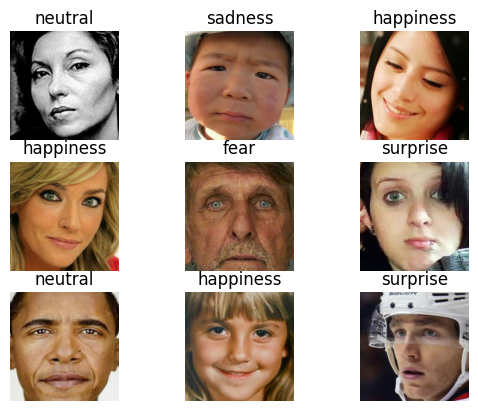

In [33]:
import matplotlib.pyplot as plt

image,labels=train_ds.as_numpy_iterator().next()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i].astype('uint8'))
    plt.title(class_names[labels[i]])
    
    plt.axis('off')

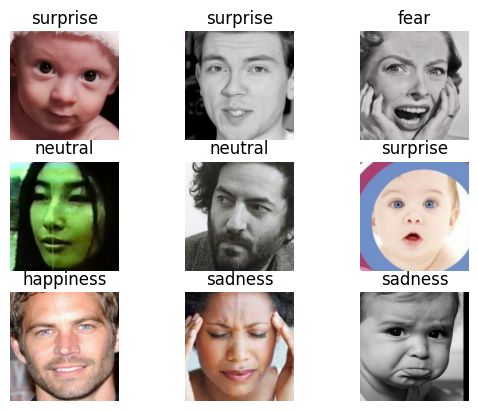

In [34]:
import matplotlib.pyplot as plt

image,labels=test_ds.as_numpy_iterator().next()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i].astype('uint8'))
    plt.title(class_names[labels[i]])
    
    plt.axis('off')

In [35]:
label_counts = {i: 0 for i in range(5)} 
for _,label_batch in train_ds:
    labels=label_batch.numpy()
    for label in labels:
        label_counts[label] += 1


In [36]:
for key,value in label_counts.items():
    print(f'{class_names[key]} : {value}')

neutral : 15037
happiness : 19445
sadness : 12676
surprise : 14090
fear : 10078


In [37]:
for image_batch,label_batch in test_ds.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 224, 224, 3)
(32,)


In [38]:
train_batches=tf.data.experimental.cardinality(train_ds)
train_batches

<tf.Tensor: shape=(), dtype=int64, numpy=2229>

In [39]:
val_ds=train_ds.take(train_batches//5)
train_ds=train_ds.skip(train_batches//5)

In [40]:
print(len(val_ds))
print(len(train_ds))

445
1784


In [41]:
label_counts = {i: 0 for i in range(5)} 
for _,label_batch in test_ds:
    labels=label_batch.numpy()
    for label in labels:
        label_counts[label] += 1



In [42]:
for key,value in label_counts.items():
    print(f'{class_names[key]} : {value}')

neutral : 500
happiness : 500
sadness : 500
surprise : 500
fear : 500


In [43]:
label_counts = {i: 0 for i in range(5)} 
for _,label_batch in train_ds:
    labels=label_batch.numpy()
    for label in labels:
        label_counts[label] += 1



In [44]:
for key,value in label_counts.items():
    print(f'{class_names[key]} : {value}')

neutral : 12033
happiness : 15552
sadness : 10104
surprise : 11296
fear : 8101


In [45]:
label_counts = {i: 0 for i in range(5)} 
for _,label_batch in val_ds:
    labels=label_batch.numpy()
    for label in labels:
        label_counts[label] += 1



In [46]:
for key,value in label_counts.items():
    print(f'{class_names[key]} : {value}')

neutral : 3004
happiness : 3893
sadness : 2572
surprise : 2794
fear : 1977


In [47]:
print(len(test_ds))
print(len(val_ds))
print(len(train_ds))


79
445
1784


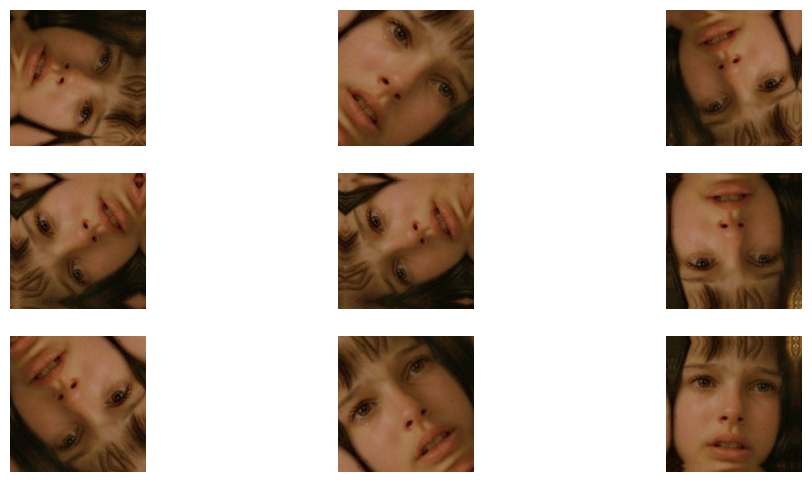

In [99]:
img_size=(224,224)
img_shape=img_size+(3,)
data_aug=tf.keras.Sequential([layers.RandomFlip('horizontal_and_vertical',input_shape=img_shape),
                              layers.RandomRotation(0.2),
                              layers.RandomZoom(0.2)])
plt.figure(figsize=(12,6))
for images,_ in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        augmented_image=data_aug(images)
        plt.imshow(augmented_image[2].numpy().astype('uint8'))
        plt.axis('off')
                              

In [100]:
preprocess_input=tf.keras.applications.vgg16.preprocess_input

In [101]:
weight_path='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [102]:
img_shape=img_size+(3,)
base_model = tf.keras.applications.VGG16(input_shape=img_shape,
                                               include_top=False,
                                               weights=None)

In [103]:
base_model.load_weights(weight_path)


In [104]:
base_model.trainable=False

In [105]:
global_avg_layer=layers.GlobalAveragePooling2D()
prediction_layer=layers.Dense(5)

In [107]:
inputs=tf.keras.Input(shape=(img_shape))
x=data_aug(inputs)
x=preprocess_input(x)
x=base_model(x,training=False)
x=global_avg_layer(x)
# x=layers.Dropout(0.2)(x)
outputs=prediction_layer(x)
model=tf.keras.Model(inputs,outputs)

In [108]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [109]:
initial_epochs = 10
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)


Epoch 1/10


1783/1784 [============================>.] - ETA: 0s - loss: 2.5639 - accuracy: 0.2702

2024-03-03 21:05:53.371637: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 21:05:53.372322: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 21:05:53.481467: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1784/1784 [==============================] - 347s 194ms/step - loss: 2.5636 - accuracy: 0.2702 - val_loss: 2.0094 - val_accuracy: 0.3026
Epoch 2/10
1784/1784 [==============================] - 345s 193ms/step - loss: 1.8246 - accuracy: 0.3419 - val_loss: 1.7250 - val_accuracy: 0.3534
Epoch 3/10
1784/1784 [==============================] - 348s 195ms/step - loss: 1.6072 - accuracy: 0.3783 - val_loss: 1.5909 - val_accuracy: 0.3820
Epoch 4/10
1784/1784 [==============================] - 347s 194ms/step - loss: 1.5015 - accuracy: 0.4003 - val_loss: 1.5185 - val_accuracy: 0.3941
Epoch 5/10
1784/1784 [==============================] - 349s 195ms/step - loss: 1.4382 - accuracy: 0.4158 - val_loss: 1.4590 - val_accuracy: 0.4061
Epoch 6/10
1784/1784 [==============================] - 348s 195ms/step - loss: 1.3878 - accuracy: 0.4319 - val_loss: 1.4294 - val_accuracy: 0.4116
Epoch 7/10
1784/1784 [==============================] - 347s 194ms/step - loss: 1.3577 - accuracy: 0.4400 - val_loss: 1.407

In [ ]:

model.save('NewModels/affectnet_CNN_VGG_FIVEEMO.h5')
import pickle


with open('NewModels/history_affectnet_CNN_VGG_FIVEEMO_hisonly.pkl', 'wb') as file:
    pickle.dump(history.history, file)  
    

In [114]:
base_model.trainable=True

In [115]:
print('Total layers',len(base_model.layers))


Total layers 19


In [116]:
fine_tune_at=10
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable=False

In [117]:
base_learning_rate=0.0001
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [118]:
total_epochs =  10

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         validation_data=val_ds)

Epoch 1/10


1784/1784 [==============================] - 502s 279ms/step - loss: 1.0872 - accuracy: 0.5590 - val_loss: 0.9642 - val_accuracy: 0.6159
Epoch 2/10
1784/1784 [==============================] - 498s 279ms/step - loss: 0.9551 - accuracy: 0.6164 - val_loss: 0.8958 - val_accuracy: 0.6407
Epoch 3/10
1784/1784 [==============================] - 499s 279ms/step - loss: 0.8958 - accuracy: 0.6430 - val_loss: 0.8689 - val_accuracy: 0.6565
Epoch 4/10
1784/1784 [==============================] - 499s 279ms/step - loss: 0.8576 - accuracy: 0.6597 - val_loss: 0.8404 - val_accuracy: 0.6655
Epoch 5/10
1784/1784 [==============================] - 499s 279ms/step - loss: 0.8302 - accuracy: 0.6709 - val_loss: 0.8302 - val_accuracy: 0.6732
Epoch 6/10
1784/1784 [==============================] - 499s 279ms/step - loss: 0.8100 - accuracy: 0.6787 - val_loss: 0.8118 - val_accuracy: 0.6789
Epoch 7/10
1784/1784 [==============================] - 499s 279ms/step - loss: 0.7914 - accuracy: 0.6846 - val_loss: 0.816

In [121]:
model.save('NewModels/affectnet_CNN_VGG_FIVEEMO_FINE_FINAL.h5')


with open('NewModels/history_affectnet_CNN_VGG_FIVEEMO_FINE_FINAL.pkl', 'wb') as file:
    pickle.dump(history_fine.history, file)  


/home/ashim/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [62]:
model_fine=tf.keras.models.load_model('/Users/anmolchalise/Desktop/AI_ML_model/affectnet_CNN_VGG_FIVEEMO_FINE_FINAL.h5')

import pickle


with open('/Users/anmolchalise/Downloads/history_affectnet_CNN_VGG_FIVEEMO_FINE_FINAL.pkl', 'rb') as file:
    history_fine = pickle.load(file)
    


with open('/Users/anmolchalise/Downloads/history_affectnet_CNN_VGG_FIVEEMO.pkl', 'rb') as file:
    history = pickle.load(file)
    
    

In [63]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions=model_fine.predict_on_batch(image_batch)
predctions=tf.nn.softmax(predictions)
predictions=tf.argmax(predictions,axis=1)
predictions=predictions.numpy()

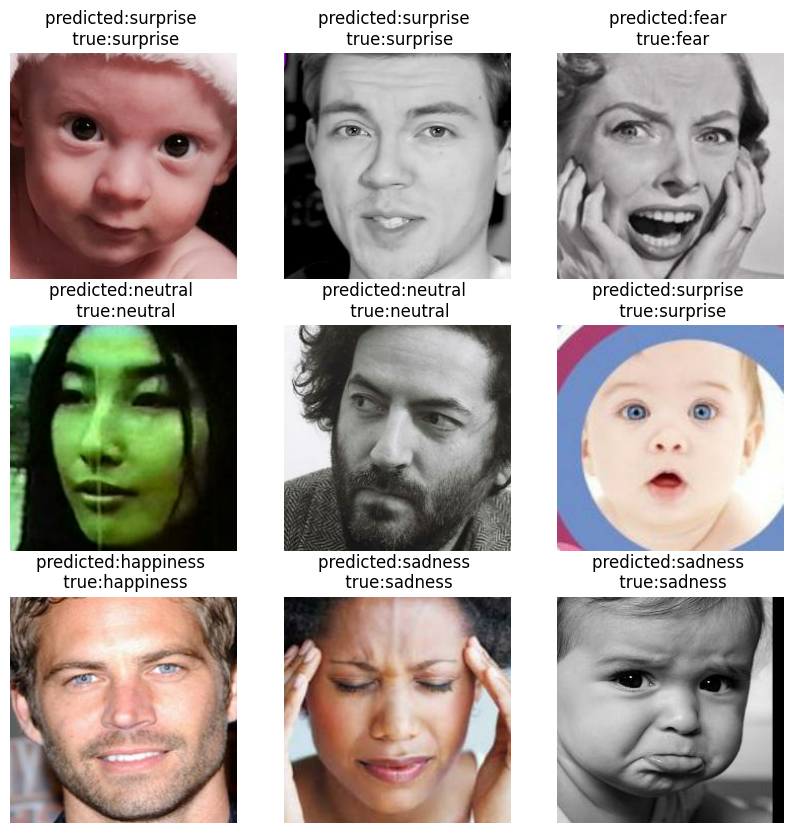

In [64]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i].astype('uint8'))
    true_label=class_names[label_batch[i]]
    predicted_label=class_names[predictions[i]]
    plt.title(f'predicted:{predicted_label} \n true:{true_label}')
    plt.axis('off')

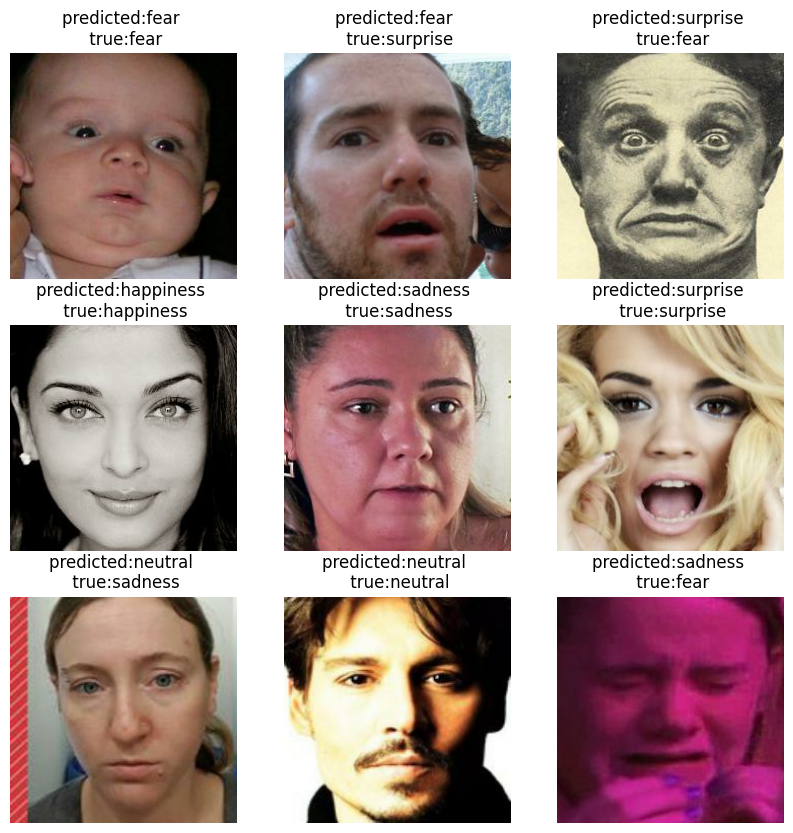

In [65]:
plt.figure(figsize=(10,10))
for i in range(9,18):
    plt.subplot(3,3,i-8)
    plt.imshow(image[i].astype('uint8'))
    true_label=class_names[label_batch[i]]
    predicted_label=class_names[predictions[i]]
    plt.title(f'predicted:{predicted_label} \n true:{true_label}')
    plt.axis('off')

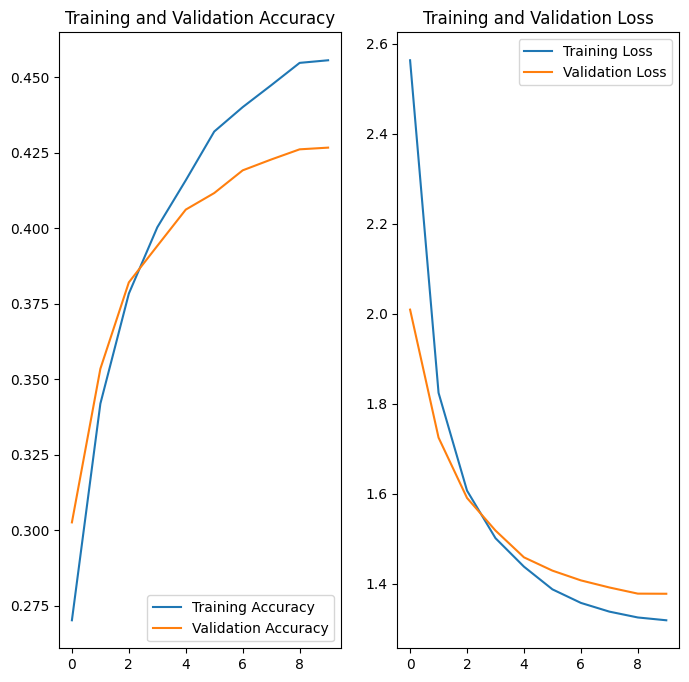

In [66]:
epochs=10
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

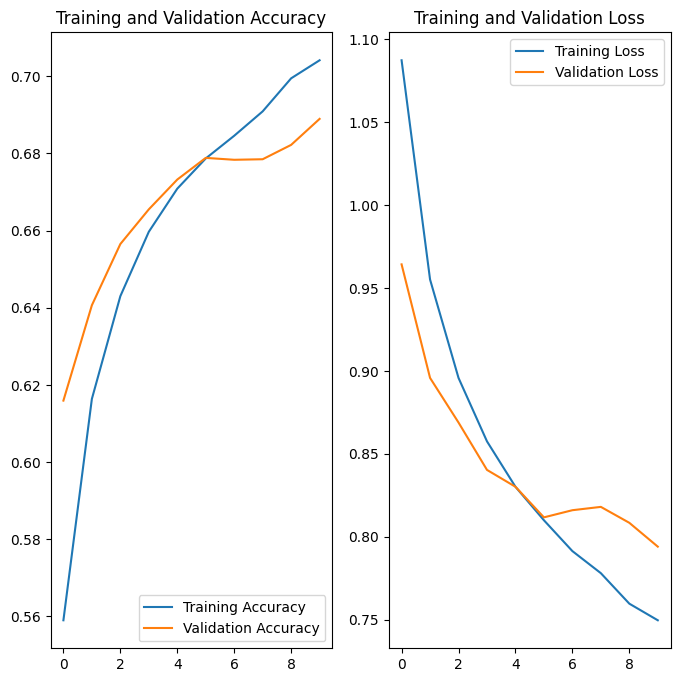

In [67]:
epochs=10
acc = history_fine['accuracy']
val_acc = history_fine['val_accuracy']

loss = history_fine['loss']
val_loss = history_fine['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [68]:
predictions=model_fine.predict_on_batch(image_batch)
predictions=tf.nn.softmax(predictions)

0 0 neutral neutral


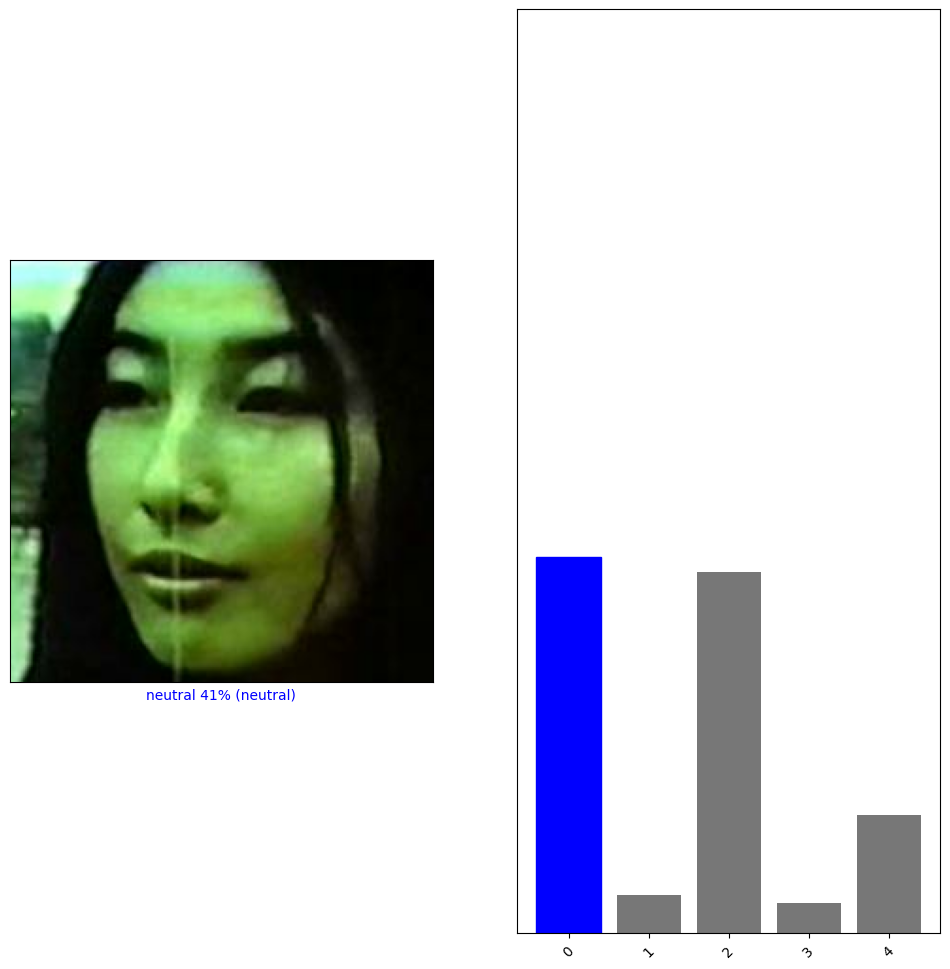

In [69]:
def plot_img(i,prediction_array,label_batch,img):
    true_label,img=label_batch[i],img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.astype('uint8'))

    prediction_label=np.argmax(prediction_array)

    if prediction_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[prediction_label],
                                100*np.max(prediction_array),
                                class_names[true_label]),
                                color=color)


def plot_val(i,prediction_array,true_label):
    prediction_label=np.argmax(prediction_array)
    true_label=true_label[i]
    plt.xticks(range(5),class_names,rotation=45)
    plt.ylim([0,1])
    plt.yticks([])
    this_plot=plt.bar(range(5),prediction_array,color="#777777")

    print(prediction_label,true_label,class_names[prediction_label],class_names[true_label])
    this_plot[prediction_label].set_color('red')
    this_plot[true_label].set_color('blue')




i=3
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)

plot_img(i,predictions[i],label_batch,image_batch)
plt.subplot(1,2,2)
plot_val(i,predictions[i],label_batch)
plt.savefig('affectnet_fine_tune_plot.png')


3 3 surprise surprise
3 3 surprise surprise
4 4 fear fear
0 0 neutral neutral
0 0 neutral neutral
3 3 surprise surprise
1 1 happiness happiness
2 2 sadness sadness
2 2 sadness sadness


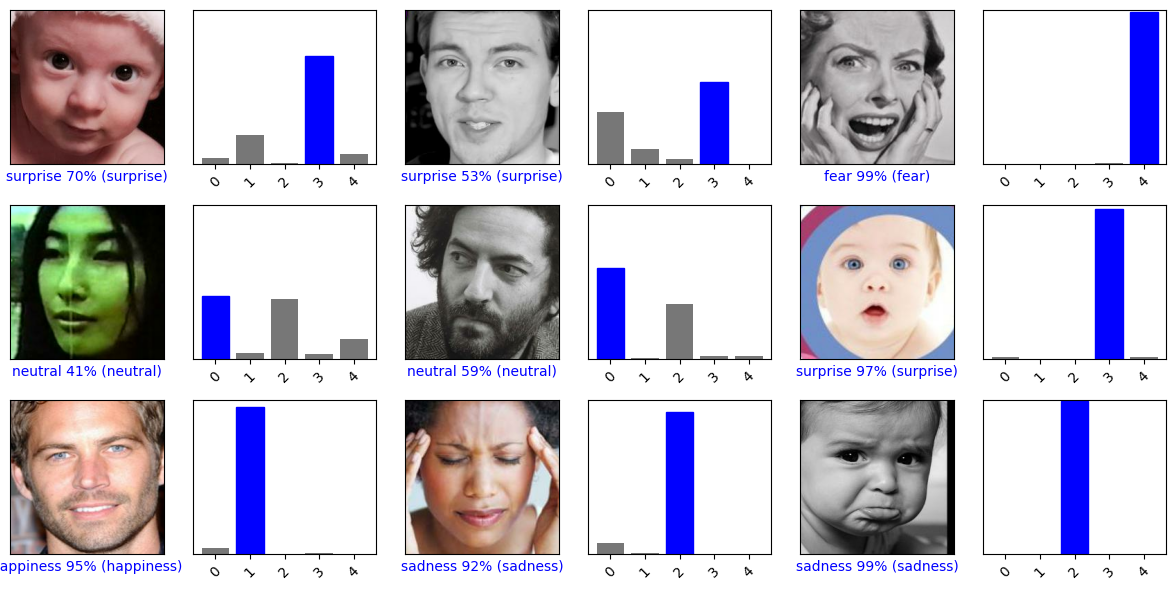

In [71]:
n_rows=3
n_cols=3
total_num=n_rows*n_cols
plt.figure(figsize=(2*2*n_rows,2*n_cols))
j=0
for i in range(0,9):
  
  plt.subplot(n_rows,2*n_cols,2*j+1)
  plot_img(i,predictions[i],label_batch,image_batch)
  plt.subplot(n_rows,2*n_cols,2*j+2)
  plot_val(i,predictions[i],label_batch)
  j=j+1
plt.tight_layout()
plt.show()


In [73]:
import numpy as np
from sklearn.metrics import confusion_matrix


true_labels_all = []
predicted_labels_all = []
i=0
for batch in test_ds:
    images, true_labels = batch
    predicted_labels = model_fine.predict_on_batch(images)
    predicted_labels=tf.nn.softmax(predicted_labels)
    predicted_labels = np.argmax(predicted_labels, axis=1)
    true_labels_all.extend(true_labels.numpy())
    predicted_labels_all.extend(predicted_labels)

true_labels_all = np.array(true_labels_all)
predicted_labels_all = np.array(predicted_labels_all)

conf_matrix = confusion_matrix(true_labels_all, predicted_labels_all)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[328  37  90  35  10]
 [ 31 445  11  12   1]
 [108  21 346  10  15]
 [ 78  55  39 267  61]
 [ 38  18  80 100 264]]


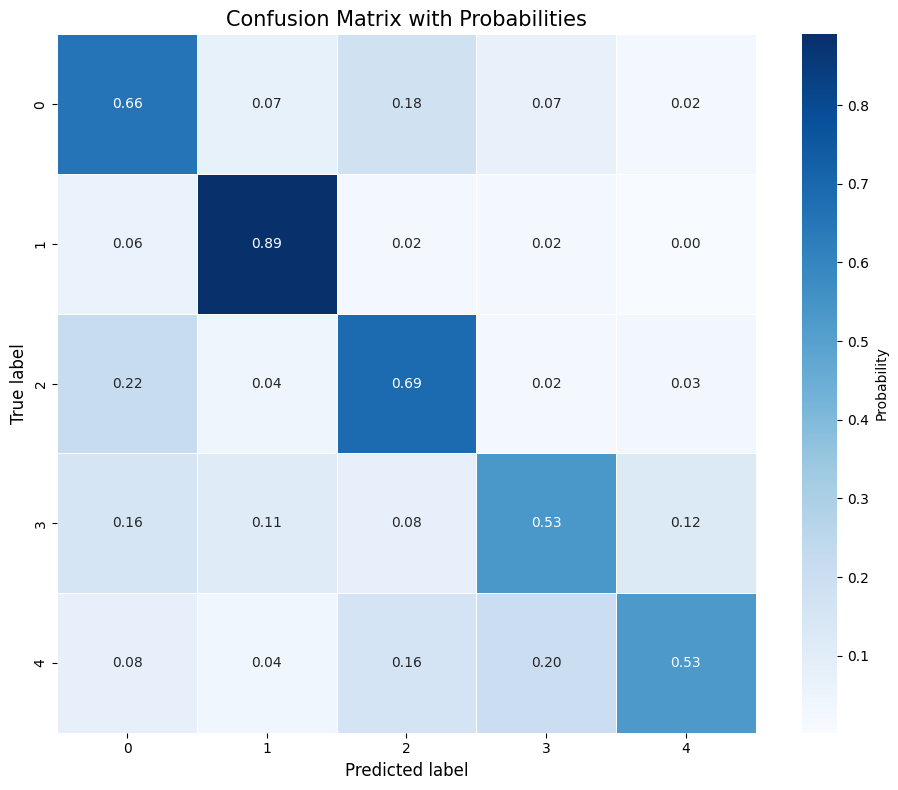

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8)) 

sns.heatmap(conf_matrix, annot=True, fmt=".2f", linewidths=0.5, square=True, cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Probability'})

plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.title('Confusion Matrix with Probabilities', fontsize=15)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

plt.savefig('confusion_matrix_final.png', dpi=300)

plt.show()


In [78]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, f1_score

pred_on_test_ds = model_fine.predict_on_batch(image_batch)
predictions=tf.nn.softmax(pred_on_test_ds)
test_ds_predicted_classes = np.argmax(predictions, axis=1)
test_ds_max_prob = np.max(pred_on_test_ds, axis=1)

precision = precision_score(label_batch, test_ds_predicted_classes,average='macro')

recall = recall_score(label_batch, test_ds_predicted_classes,average='macro')

f1 = f1_score(label_batch, test_ds_predicted_classes,average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.6933333333333331
Recall: 0.6933333333333331
F1 Score: 0.6909090909090908
